# KE5108 Time Series Forecasting

## Load Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

## Load Data

In [2]:
train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
train_ts_df.head()

,week,GRPRatingsDate,GRP
weekly_date,,,
2007-06-17,0,17-Jun-2007 (25),243.60
2007-06-24,1,24-Jun-2007 (26),263.19
2007-07-01,2,01-Jul-2007 (27),269.89
2007-07-08,3,08-Jul-2007 (28),252.88
2007-07-15,4,15-Jul-2007 (29),303.46


In [3]:
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)
test_ts_df.head()

,week,GRPRatingsDate,GRP
weekly_date,,,
2008-06-22,53,22-Jun-2008 (26),214.32
2008-06-29,54,29-Jun-2008 (27),233.76
2008-07-06,55,06-Jul-2008 (28),231.12
2008-07-13,56,13-Jul-2008 (29),224.72
2008-07-20,57,20-Jul-2008 (30),216.19


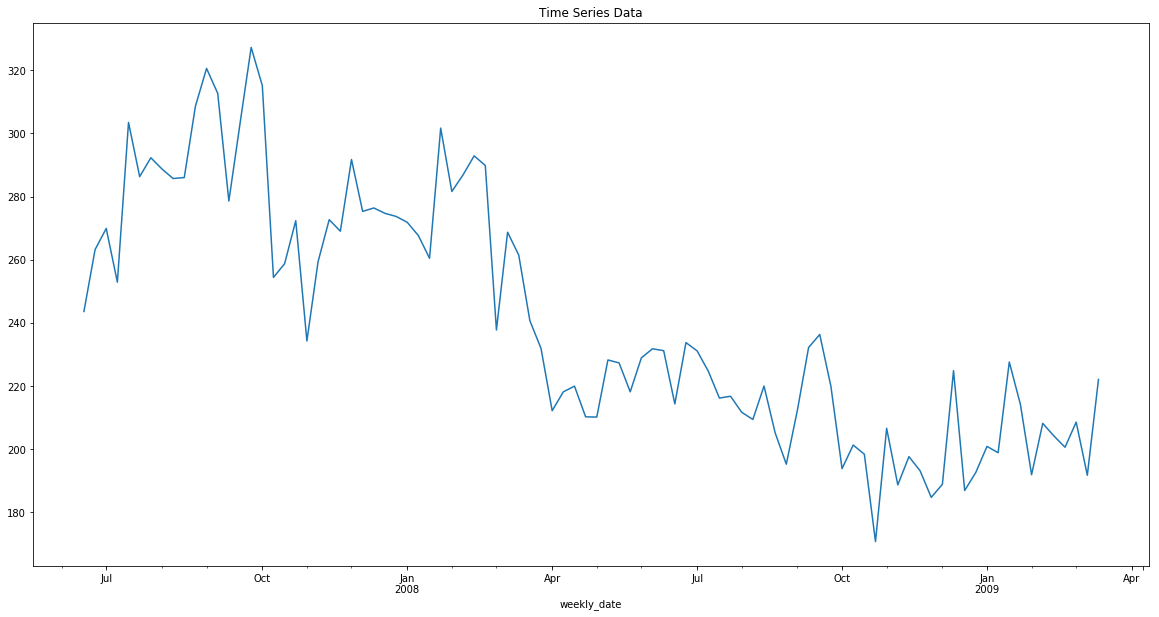

In [4]:
train_ts_df.append(test_ts_df)['GRP'].plot(figsize=(20, 10), title="Time Series Data")

## Classical Decomposition Method

In [5]:
# Number of time series periods in a season = 16 (weeks) or 4 months
def plot_decomp(ts_df, freq, model='multiplicative', two_sided=False):
    decomp = sm.tsa.seasonal_decompose(ts_df, model=model, two_sided=two_sided, freq=freq)
    fig = decomp.plot()
    fig.set_size_inches(15, 7)
    fig.get_axes()[0].set_title('Seasonal Frequency of ' + str(freq) + ' Periods')
    plt.show()
    return decomp

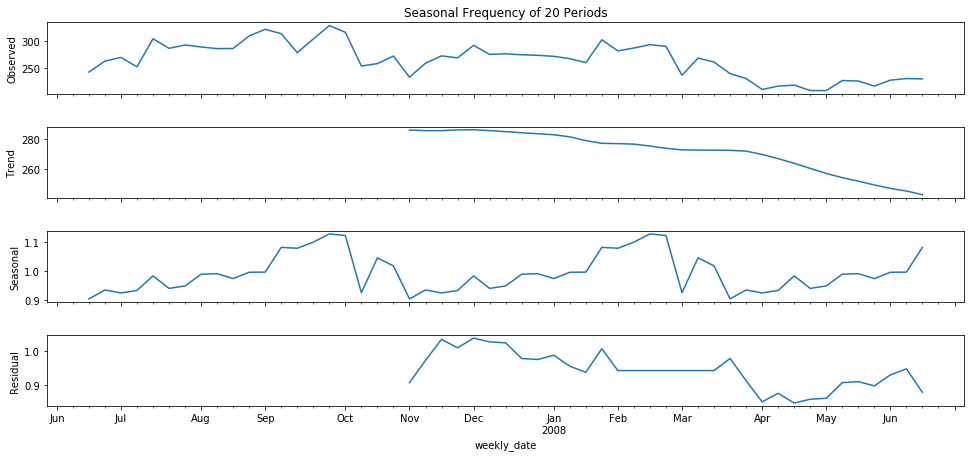

In [6]:
# Number of time series periods in a season = 20 (weeks) or 5 months
decomp20 = plot_decomp(train_ts_df['GRP'], freq=20)

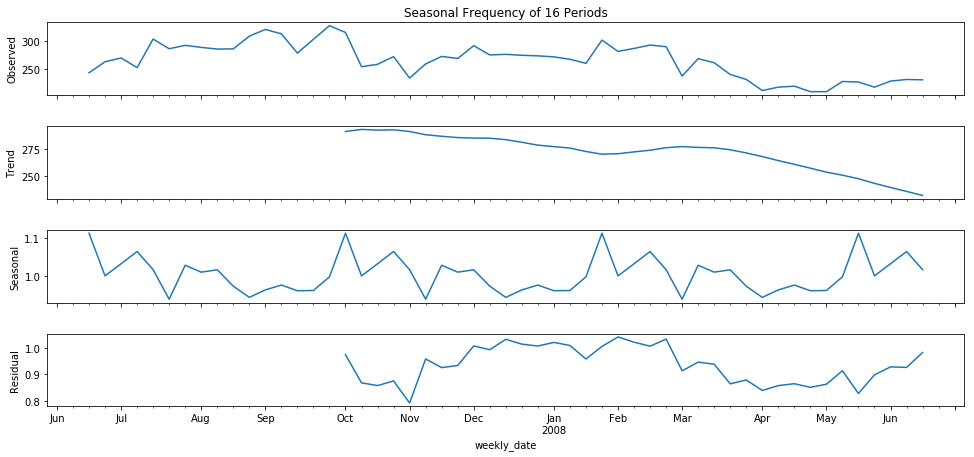

In [7]:
# Number of time series periods in a season = 16 (weeks) or 4 months
decomp16 = plot_decomp(train_ts_df['GRP'], freq=16)

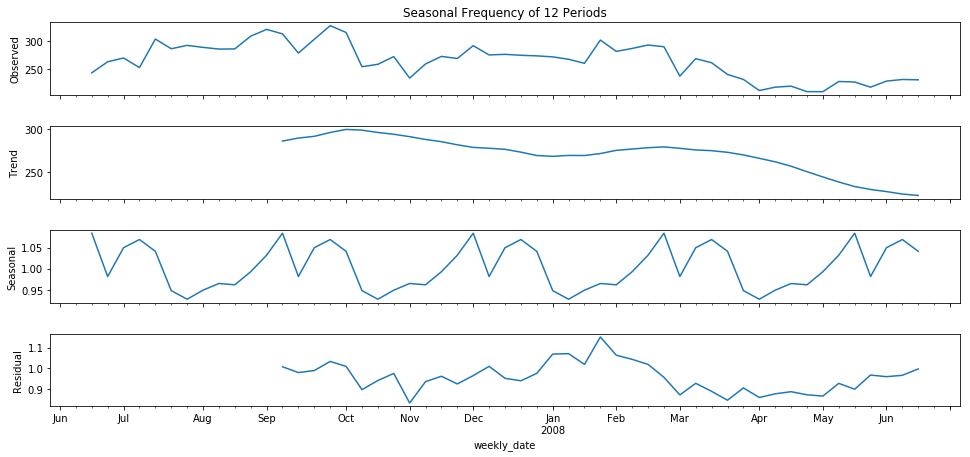

In [8]:
# Number of time series periods in a season = 12 (weeks) or 3 months
decomp12 = plot_decomp(train_ts_df['GRP'], freq=12)

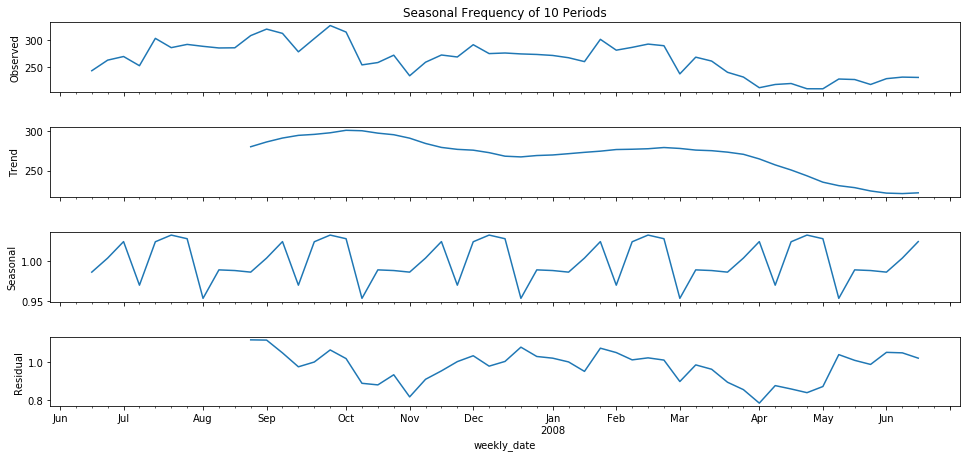

In [9]:
# Number of time series periods in a season = 10 (weeks) or 2.5 months
decomp10 = plot_decomp(train_ts_df['GRP'], freq=10)

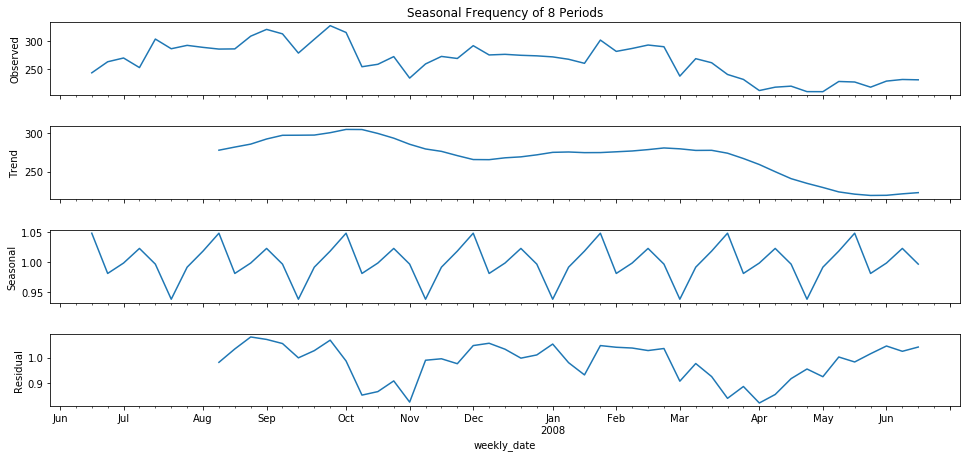

In [10]:
# Number of time series periods in a season = 8 (weeks) or 2 months
decomp8 = plot_decomp(train_ts_df['GRP'], freq=8)

### Analysis of Residuals

In [17]:
def plot_residuals(resid, isMult=True, deg=3, title='Residuals by Week'):

    a_resid = resid.copy()
    a_resid.reset_index(drop=True, inplace=True)
    a_resid.dropna(inplace=True)
    idx = a_resid.index.values.reshape(-1, 1)
    
    poly_reg = Pipeline(
        [
            ('poly', PolynomialFeatures(degree=deg)),
            ('linear', LinearRegression(fit_intercept=True))])
    poly_reg.fit(idx, a_resid)
    poly_reg_pred = poly_reg.predict(idx)
    plt.title(title)
    plt.scatter(idx, a_resid, color='black', marker='o', label='residuals', facecolors='none')
    plt.plot(idx, a_resid, color='black', linewidth=1, label='residuals curve', alpha=.5)
    plt.plot(idx, poly_reg_pred, color='blue', linewidth=3, label='regression line')
    if isMult:
        plt.axhline(1)
    else:
        plt.axhline(1)        
    plt.legend()
    return None

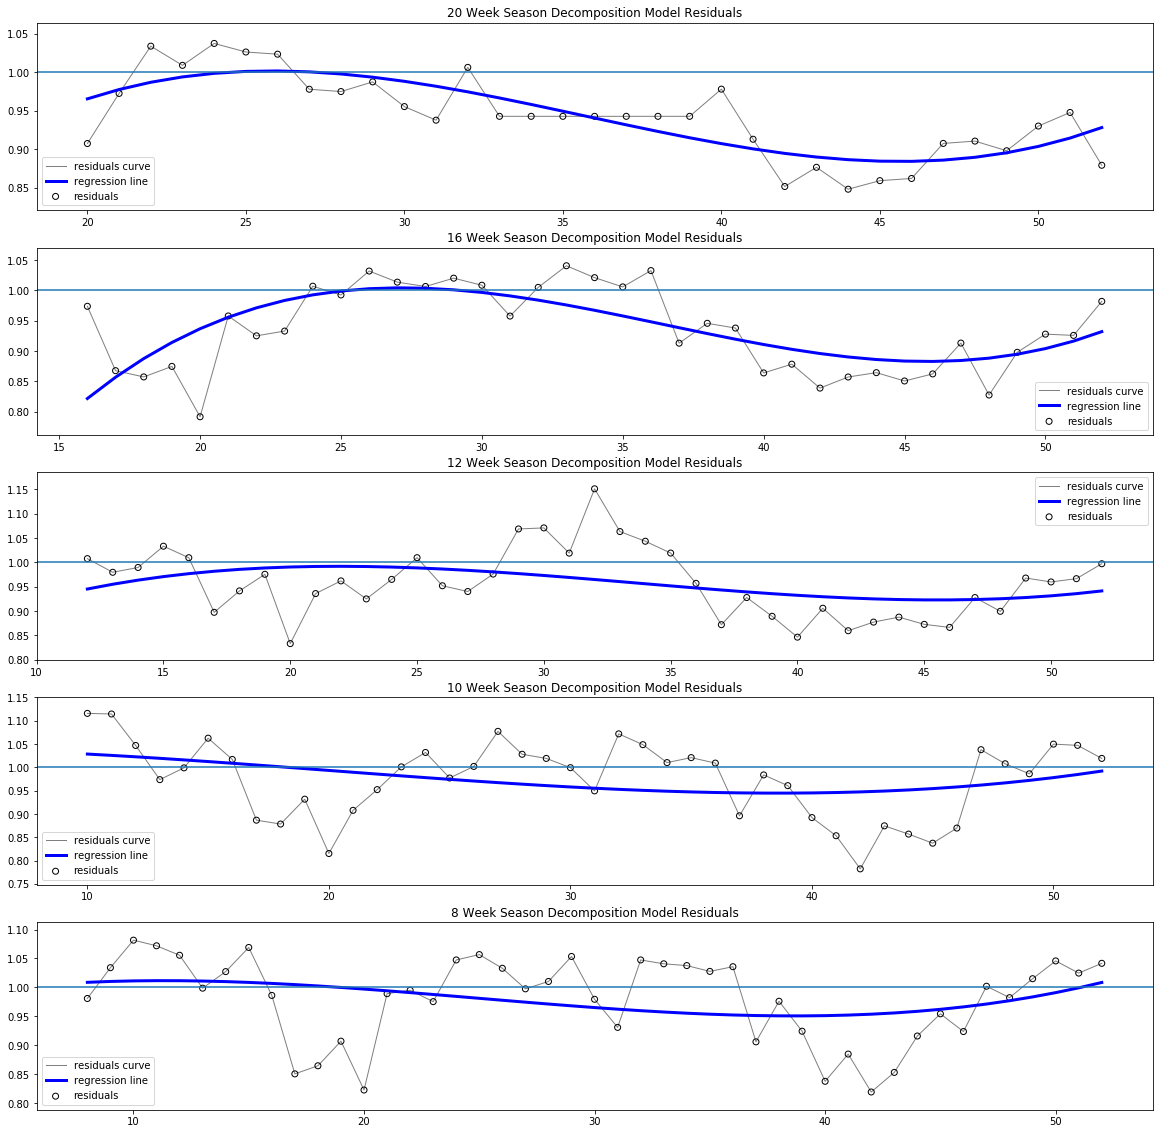

In [18]:
decomp_list = [[decomp20, 20], [decomp16, 16], [decomp12, 12], [decomp10, 10], [decomp8, 8]]
fig, ax = plt.subplots(nrows=len(decomp_list), ncols=1, figsize=(20, 20))
for idx, row in enumerate(ax):
    plt.sca(row)
    plot_residuals(decomp_list[idx][0].resid, isMult=True, deg=3, title=str(decomp_list[idx][1])+' Week Season Decomposition Model Residuals')
plt.show()

### Training / Test Results

20 Week Season Model

In [23]:
a_trend = decomp20.trend.copy()
a_trend.reset_index(drop=True, inplace=True)
a_trend.dropna(inplace=True)
idx = a_trend.index.values.reshape(-1, 1)
trend_reg = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=True))])
trend_reg.fit(idx, a_trend)
trend_reg_train_pred = trend_reg.predict(decomp20.trend.index.values.reshape(-1, 1))

In [24]:
grp_train_pred = trend_reg_train_pred * decomp20.seasonal

In [27]:
trend_reg_test_pred = trend_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
a_seasonal = 
seasonal_test = 

In [25]:
test_ts_df.head()

,week,GRPRatingsDate,GRP
weekly_date,,,
2008-06-22,53,22-Jun-2008 (26),214.32
2008-06-29,54,29-Jun-2008 (27),233.76
2008-07-06,55,06-Jul-2008 (28),231.12
2008-07-13,56,13-Jul-2008 (29),224.72
2008-07-20,57,20-Jul-2008 (30),216.19


In [ ]:
hw_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['hw'].values)
hw_train_rmse = np.sqrt(hw_train_mse)
hw_test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['hw'].values)
hw_test_rmse = np.sqrt(hw_test_mse)

results_list.append([hw_train_mse, hw_train_rmse, hw_test_mse, hw_test_rmse])